In [1]:
#librarie necessaire pour notre programme
import cv2 as cv
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from math import *
import numpy as np
import os

# chargement et lecture d'une l'image test et de son masque pour tester notre programme
image_test = cv.imread('photo.jpg')
image_test = cv.cvtColor(image_test, cv.COLOR_BGR2RGB)

# definition du chemin d'acces aux images entrainement et leurs masques

chemin_images_train = 'DATASET/Dataset8_Abdomen/train/original_images'
chemin_masque_image_train = 'DATASET/Dataset8_Abdomen/train/skin_masks'

#une fois le chemin d'acces defini, on stock les images dans des collections plus precisement dans des listes

liste_images = [ f for f in os.listdir(chemin_images_train) if os.path.isfile(os.path.join(chemin_images_train,f)) ]

liste_image_train = []
liste_masque_image_train = []

for img in liste_images:
    image = cv.imread(os.path.join(chemin_images_train, img))
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    liste_image_train.append(image)
    
for img in liste_images:
    image_mask = cv.imread(os.path.join(chemin_masque_image_train, img.split('.')[0]+'.png'), cv.IMREAD_GRAYSCALE)
    liste_masque_image_train.append(image_mask)
    
liste_image_train = np.array(liste_image_train)
liste_masque_image_train = np.array(liste_masque_image_train)
print(liste_image_train.shape)
print(liste_masque_image_train.shape)

 #On change l'espace de couleur de RGB à Lab

def convertion_RGB_LAB(liste_RGB):
    liste_lab = [0] * liste_RGB.shape[0]
    for i, img in enumerate(liste_RGB):
        liste_lab[i] = cv.cvtColor(img, cv.COLOR_RGB2LAB)
    return np.array(liste_lab)

liste_image_lab = convertion_RGB_LAB(liste_image_train)
l_channel,a_channel,b_channel = cv.split(liste_image_lab[13])

# On convertie l'intervalle dans lequel les pixels prennent leurs valeurs pour les dimensions a et b
ECHELLE = 132
def reduire_dimention_lab(t_img):
    temp = [0] * 256
    for i in range(256):
        temp[i] = floor(i / (256/ECHELLE))
    
    for index, img in enumerate(t_img):
        h, w, d = img.shape
        image = np.asarray(np.zeros((h, w, d), dtype=np.uint8))

        for i in range(h):
            for j in range(w):
                for k in range(1, 3):
                    image[i, j][k] = temp[img[i, j][k]]
                image[i, j][0] = img[i, j][0]
        t_img[index] = image
        
    return t_img
img_lab_convert = reduire_dimention_lab(liste_image_lab)

l_channel,a_channel,b_channel = cv.split(img_lab_convert[13])

SEUIL = 100
# fonction pour calculer l'histogramme peau

def histogram_peau(liste_image_lab, liste_masque):
    z = np.zeros((ECHELLE, ECHELLE))
    
    for index, img in enumerate(liste_image_lab):
        l_channel, a_channel, b_channel = cv.split(img)
        masque = liste_masque[index]
    
        x, y = a_channel.shape
        
        for i in range(x):
            for j in range(y):
                if masque[i][j] > SEUIL:
                    x_ = a_channel[i, j]
                    y_ = b_channel[i, j]
                    z[x_, y_] += 1
    return z / sum(sum(z)), sum(sum(z))


# fonction pour calculer l'histogramme non peau

def histogram_non_peau(liste_image_lab, liste_masque):
    z = np.zeros((ECHELLE, ECHELLE))
    
    for index, img in enumerate(liste_image_lab):
        l_channel, a_channel, b_channel = cv.split(img)
        masque = liste_masque[index]
    
        x, y = a_channel.shape
        
        for i in range(x):
            for j in range(y):
                if masque[i][j] < SEUIL:
                    x_ = a_channel[i, j]
                    y_ = b_channel[i, j]
                    z[x_, y_] += 1
    return z / sum(sum(z)), sum(sum(z))


x = np.linspace(0, ECHELLE-1, ECHELLE)
y = np.linspace(0, ECHELLE-1, ECHELLE)

X, Y = np.meshgrid(x, y)

Z_peau, total_peau = histogram_peau(img_lab_convert, liste_masque_image_train)
Z_non_peau, total_non_peau = histogram_non_peau(img_lab_convert, liste_masque_image_train)

# detection peau et non peau avec la methode de bayes


def evaluation_peau(a, b, Z_peau, Z_non_peau):
    p_peau = Z_peau[a, b]
    p_non_peau = Z_non_peau[a, b]
    return np.argmax([p_non_peau, p_peau])

def evaluation_peau_bayes(a, b, Z_peau, Z_non_peau, t_p, t_n_p):
    try:
        u = Z_peau[a, b] * (t_p / (t_p + t_n_p))
        p_peau = u / (u + (Z_non_peau[a, b] * (t_n_p / (t_p + t_n_p))))
    except:
        return 0
    return p_peau
    
def detection_peau(img, Z_peau, Z_non_peau, t_p, t_n_p, s):
    # On converti dans l'espace lab
    img_lab = cv.cvtColor(img, cv.COLOR_RGB2LAB)
    
    # On modifie les intervalles de a et b
    temp = [0] * 256
    for i in range(256):
        temp[i] = floor(i / (256/ECHELLE))
    
    h, w, d = img_lab.shape
    image = np.asarray(np.zeros((h, w, d), dtype=np.uint8))

    for i in range(h):
        for j in range(w):
            for k in range(1, 3):
                image[i, j][k] = temp[img_lab[i, j][k]]
            image[i, j][0] = img_lab[i, j][0]
    img_lab = image
    
    # On détecte la peau en mettant à 0 les pixels non peau
    for i in range(h):
        for j in range(w):
            if not evaluation_peau_bayes(img_lab[i, j][1], img_lab[i, j][2], Z_peau, Z_non_peau, t_p, t_n_p) >= s:
                for k in range(0, 3):
                    img[i, j][k] = 0
    
    return img

def peau_normale(img, masque):
    x, y = masque.shape

    for i in range(x):
        for j in range(y):
            if masque[i][j] < SEUIL:
                for k in range(0, 3):
                    img[i, j][k] = 0
                    
    return img

(1200, 227, 227, 3)
(1200, 227, 227)


In [2]:
test_skin = detection_peau(image_test.copy(), Z_peau, Z_non_peau, total_peau, total_non_peau, 0.8)

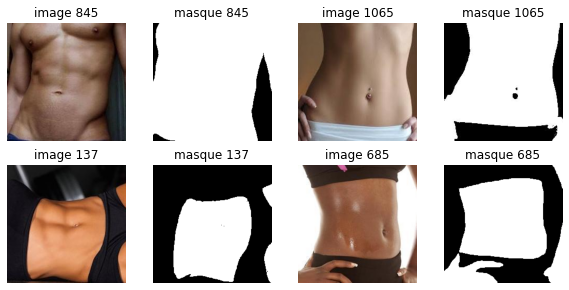

In [3]:
# Présentation de quelques images et leur masques correspondant de notre dataset

plt.figure(figsize=(10, 10))
for k, i in np.ndenumerate(np.random.randint(liste_image_train.shape[0], size=4)):
    ax = plt.subplot(4, 4, 2 * k[0] + 1)
    plt.imshow(liste_image_train[i], cmap='gray')
    plt.title('image {}'.format(i))
    plt.axis("off")
    x = plt.subplot(4, 4, 2 * k[0] + 2)
    plt.imshow(liste_masque_image_train[i], cmap='gray')
    plt.title('masque {}'.format(i))
    plt.axis("off")

(-0.5, 226.5, 226.5, -0.5)

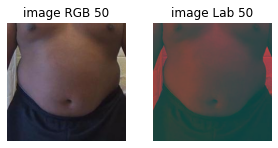

In [10]:
#  affichage d'une image dans l'espace lab avec tout les channels
i = 50
plt.figure(figsize=(10, 10))
ax = plt.subplot(4, 4, 1)
plt.imshow(liste_image_train[i])
plt.title('image RGB {}'.format(i))
plt.axis("off")

ax = plt.subplot(4, 4, 2)
plt.imshow(liste_image_lab[i])
plt.title('image Lab {}'.format(i))
plt.axis("off")



(-0.5, 226.5, 226.5, -0.5)

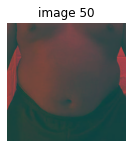

In [11]:

# affichage de l'image dans l'espace de couleur LAB avec les channels A et B uniquement
i = 50
plt.figure(figsize=(10, 10))
ax = plt.subplot(4, 4, 1)
plt.imshow(img_lab_convert[i])
plt.title('image {}'.format(i))
plt.axis("off")



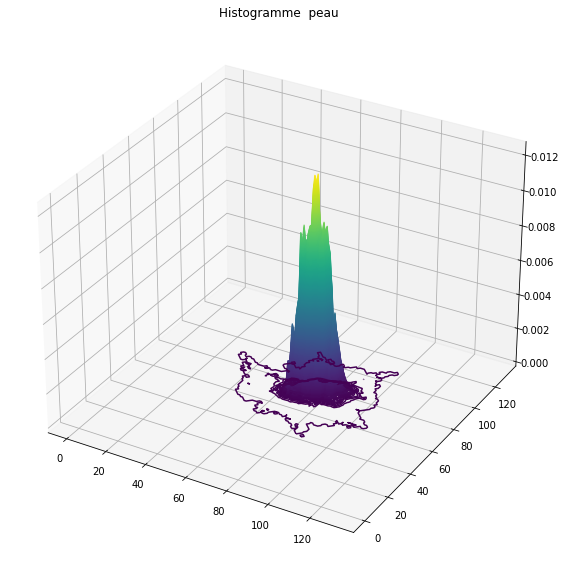

In [12]:
#affichage de l'histogramme peau
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d') 
plt.title('Histogramme  peau')
ax.contour3D(X, Y, Z_peau, 500)

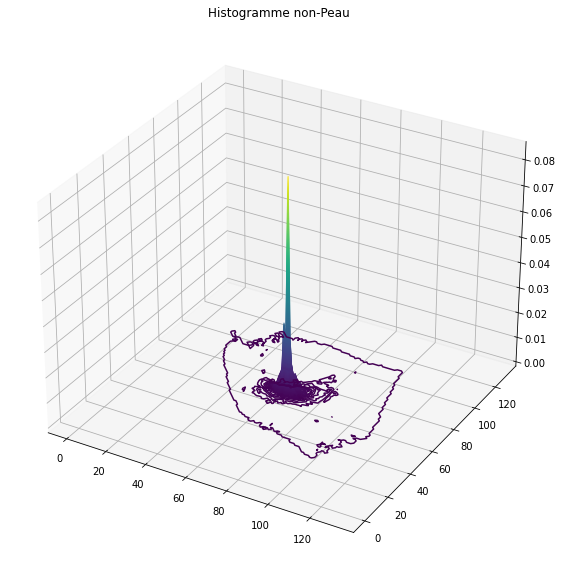

In [13]:
#affichage de l'histogramme non peau
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
plt.title("Histogramme non-Peau")
ax.contour3D(X, Y, Z_non_peau, 500)


(-0.5, 1279.5, 597.5, -0.5)

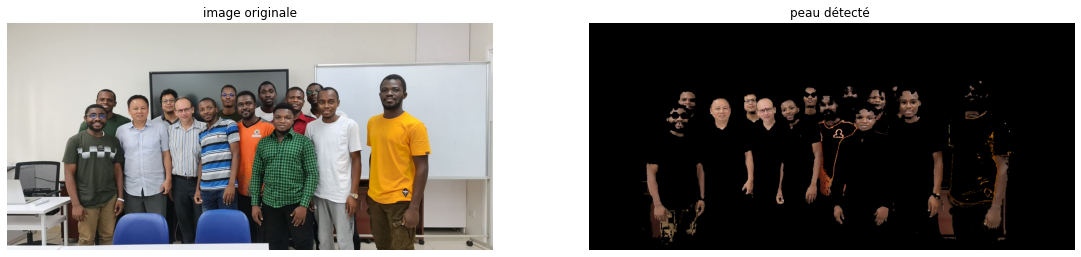

In [14]:
#détection de la peau
plt.figure(figsize=(40, 40))
ax = plt.subplot(4, 4, 1)
plt.imshow(image_test)
plt.title('image originale')
plt.axis("off")

ax = plt.subplot(4, 4, 2)
plt.imshow(test_skin)
plt.title('peau détecté ')
plt.axis("off")